In [1]:
import torch
from alphatoe import plot, game
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload

In [2]:
torch.set_grad_enabled(False)

def numpy(t):
    return t.cpu().numpy()

In [3]:
weights = torch.load("../scripts/models/prob all 8 layer control-20230718-185339.pt")
with open("../scripts/models/prob all 8 layer control-20230718-185339.json", "r") as f:
    args= json.load(f)

In [4]:
model_cfg = HookedTransformerConfig(
        n_layers=args["n_layers"],
        n_heads=args["n_heads"],
        d_model=args["d_model"],
        d_head=args["d_head"],
        d_mlp=args["d_mlp"],
        act_fn=args["act_fn"],
        normalization_type=args["normalization_type"],
        d_vocab=11,
        d_vocab_out=10,
        n_ctx=10,
        init_weights=True,
        device=args["device"],
        seed=args["seed"])

In [5]:
model =  HookedTransformer(model_cfg)
model.load_state_dict(weights)

<All keys matched successfully>

In [6]:
n_heads = 8

We = model.W_E
pos_emb = model.pos_embed(torch.zeros(1, 10, 128), 0)[0]

Wq = model.blocks[0].attn.W_Q
Wk = model.blocks[0].attn.W_K
Wv = model.blocks[0].attn.W_V
Wo = model.blocks[0].attn.W_O

device = We.device

In [22]:
Wq[0].shape

torch.Size([128, 16])

In [7]:
# SVD code from gpt-omics
class SVD:
    def __init__(self, U: torch.Tensor, S: torch.Tensor, Vt: torch.Tensor):
        self.U = U
        self.S = S
        self.Vt = Vt

    def __matmul__(self, other):
        if isinstance(other, torch.Tensor):
            other = SVD.frommatrix(other)

        # "inner core" of the product, p -> prime
        Sp = (self.S[:, None] * self.Vt) @ (other.U * other.S)

        Up, Sp, Vtp = torch.linalg.svd(Sp, full_matrices=False)

        return SVD(self.U @ Up, Sp, Vtp @ other.Vt)

    @property
    def T(self):
        return SVD(self.Vt.T, self.S, self.U.T)

    @classmethod
    def frommatrix(cls, M: torch.Tensor):
        if len(M.shape) == 1:
            norm = torch.linalg.norm(M)
            return SVD(
                (M / norm).reshape(-1, 1),
                torch.tensor([norm], dtype=M.dtype, device=M.device),
                torch.tensor([1], dtype=M.dtype, device=M.device).reshape(1, 1),
            )

        U, S, Vt = torch.linalg.svd(M, full_matrices=False)

        return SVD(U, S, Vt)

def zeropad(v: torch.Tensor, newlen: int):
    """Pads the end of a vector with zeros for elementwise multiplication."""
    assert len(v) <= newlen, f"cannot zeropad to a smaller length {len(v)}->{newlen}"

    newv = torch.zeros((newlen,), dtype=v.dtype, device=v.device)
    newv[: len(v)] = v[:]

    return newv

def overlap(svd1, svd2):
    final_dims = min(len(svd1.S), len(svd2.S))
    s1 = svd1.S[:final_dims]
    s2 = svd2.S[:final_dims]
    return (
        torch.linalg.norm((svd1 @ svd2).S)
        / torch.linalg.norm(s1 * s2)
    )

In [8]:
Wqks = [SVD.frommatrix(Wq[i]) @ SVD.frommatrix(Wk[i]).T for i in range(8)]
# transposing these to keep the convention of U -> output space and Vt -> input space
Wovs = [(SVD.frommatrix(Wv[i]) @ SVD.frommatrix(Wo[i])).T for i in range(8)]

In [28]:
print(Wovs[0].U.shape)
print(Wovs[0].Vt.shape)
print(Wovs[0].S.shape)

torch.Size([128, 16])
torch.Size([16, 128])
torch.Size([16])


# Do the OV matrices read and/or write to the same subspaces?

In [9]:
input_overlaps = torch.empty(n_heads, n_heads, device=device)
output_overlaps = torch.empty(n_heads, n_heads, device=device)

for i in range(n_heads):
    for j in range(n_heads):
        input_overlaps[i, j] = overlap(Wovs[i], Wovs[j].T)
        output_overlaps[i, j] = overlap(Wovs[i].T, Wovs[j])

In [10]:
def heatmap(t, vmin=None, vmax=None):
    data = numpy(t)

    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()

    plt.imshow(data, cmap="jet", vmin=vmin, vmax=vmax)

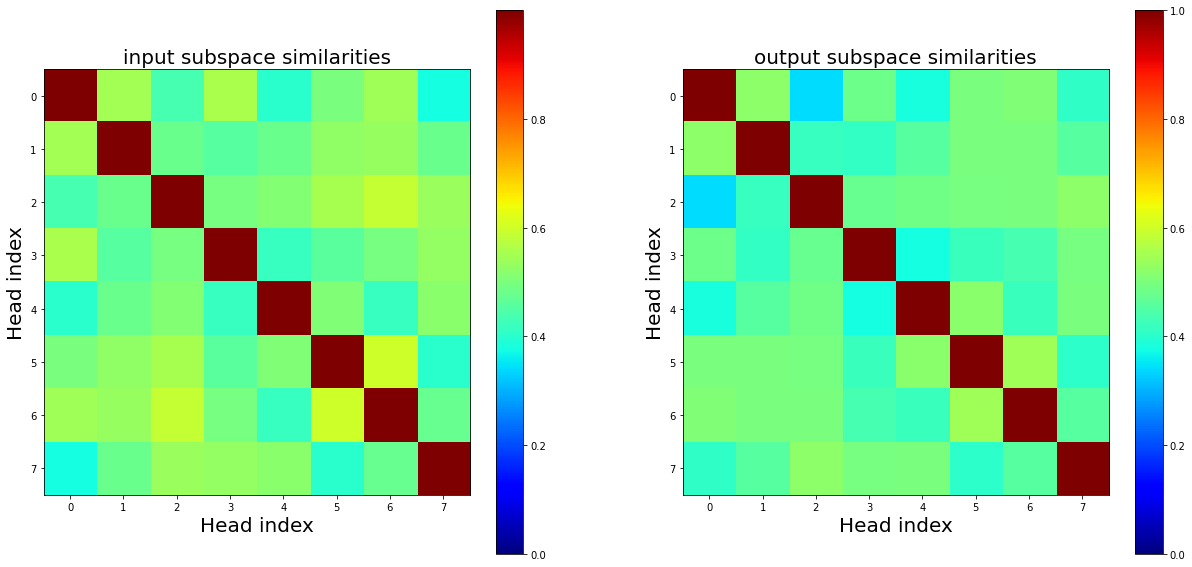

In [11]:
plt.figure(figsize=(21, 10))

plt.subplot(1, 2, 1)
heatmap(input_overlaps, vmin=0)
plt.title(f"input subspace similarities", fontsize=20)

plt.xlabel("Head index", fontsize=20)
plt.ylabel("Head index", fontsize=20)
plt.colorbar()


plt.subplot(1, 2, 2)
heatmap(output_overlaps, vmin=0)
plt.title(f"output subspace similarities", fontsize=20)

plt.xlabel("Head index", fontsize=20)
plt.ylabel("Head index", fontsize=20)
plt.colorbar()


plt.show()


# Do the attention head output subspaces match the token embedding or position embedding subspaces?

In [47]:
We_svd = SVD.frommatrix(We)
pos_emb_svd = SVD.frommatrix(pos_emb)

def nullspace(mat):
    m, n = mat.shape
    orig_svd = SVD(*torch.linalg.svd(mat, full_matrices=True))
    d = min(m, n)
    d_null = max(m, n) - d

    print(f"orig_svd.U.shape: {orig_svd.U.shape}")
    print(f"orig_svd.S.shape: {orig_svd.S.shape}")
    print(f"orig_svd.Vt.shape: {orig_svd.Vt.shape}")
    orig_svd.S = torch.ones((d_null,), device=mat.device)
    if orig_svd.U.shape[0] == d:
        orig_svd.U = torch.eye(d_null, device=mat.device)
        orig_svd.Vt = orig_svd.Vt[d:]
    else:
        orig_svd.U = orig_svd.U[:, d:]
        orig_svd.Vt = torch.tensor(d_null, device=mat.device)

    return orig_svd

We_null = nullspace(We)
pos_null = nullspace(pos_emb)

orig_svd.U.shape: torch.Size([11, 11])
orig_svd.S.shape: torch.Size([11])
orig_svd.Vt.shape: torch.Size([128, 128])
orig_svd.U.shape: torch.Size([10, 10])
orig_svd.S.shape: torch.Size([10])
orig_svd.Vt.shape: torch.Size([128, 128])


In [43]:
We.shape

torch.Size([11, 128])

In [44]:
print(We_null.U)
print(We_null.Vt)
print(We_null.S)
friends = We_null.U @ We_null.S @ We_null.Vt
print(friends)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')
tensor([[-0.0033, -0.0933, -0.0026,  ...,  0.0458,  0.0088,  0.0175],
        [-0.0399, -0.0212, -0.1569,  ..., -0.0219,  0.0136,  0.0256],
        [-0.0464, -0.0273, -0.0504,  ...,  0.0180,  0.0273,  0.0358],
        ...,
        [-0.0709,  0.1798,  0.0289,  ...,  0.8976,  0.0054, -0.0240],
        [ 0.0653, -0.0168,  0.0555,  ...,  0.0020,  0.9228, -0.0157],
        [ 0.1424,  0.0168,  0.0697,  ..., -0.0384, -0.0145,  0.9035]],
       device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.,

In [13]:
content_overlaps = torch.tensor([overlap(We_svd, Wovs[i]) for i in range(n_heads)])
position_overlaps = torch.tensor([overlap(pos_emb_svd, Wovs[i]) for i in range(n_heads)])
content_null_overlaps = torch.tensor([overlap(We_null, Wovs[i]) for i in range(n_heads)])
position_null_overlaps = torch.tensor([overlap(pos_null, Wovs[i]) for i in range(n_heads)])

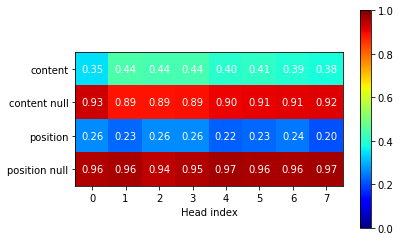

In [48]:
heatmap(
    torch.stack(
        (content_overlaps, content_null_overlaps, position_overlaps, position_null_overlaps)
        , axis=0
    ),
    vmin=0, vmax=1
)

plt.colorbar()
plt.yticks([0, 1, 2, 3], labels=["content", "content null", "position", "position null"])
plt.xlabel("Head index")
#label the squares
for i in range(4):
    for j in range(8):
        plt.text(j, i, f"{float(numpy(torch.stack((content_overlaps, content_null_overlaps, position_overlaps, position_null_overlaps), axis=0)[i, j])):.2f}", ha="center", va="center", color="w")
plt.show()

#### Do the pos embedding and content spaces overlap?

In [15]:
overlap(We_svd, pos_emb_svd.T)

tensor(0.2329, device='cuda:0')

Not much, and this looks similar to the magnitude of overlap between pos embed and the attention outputs, so this probably explains that.

# Do all of the heads send the same amount of information to the mlp?

In [16]:
mlp_in = SVD.frommatrix(model.blocks[0].mlp.W_in)

In [17]:
mlp_in.U.shape[0], mlp_in.Vt.shape[1]

(128, 512)

In [18]:
mlp_overlaps = torch.tensor([overlap(Wovs[i].T, mlp_in) for i in range(n_heads)])

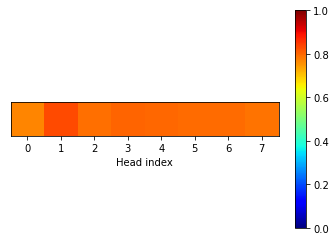

In [19]:
heatmap(mlp_overlaps.unsqueeze(0), vmin=0, vmax=1)

plt.colorbar()
plt.yticks([])
plt.xlabel("Head index")
plt.show()

In [20]:
overlap(We_svd, mlp_in), overlap(pos_emb_svd, mlp_in)

(tensor(0.6251, device='cuda:0'), tensor(0.4717, device='cuda:0'))